In [1]:
# Loading required Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from statsmodels.iolib.summary2 import summary_col
from tabulate import tabulate
import pickle

In [2]:
# Load data
github_raw_url = "../data/data.xlsx"
# Read data from GitHub raw URL
data = pd.read_excel(github_raw_url)
data

Time  House_price  Gold_price  Fixed_deposit_rate  \
0  2010-03-31         6399      243.91                4.15   
1  2010-06-30         6657      271.60                4.15   
2  2010-09-30         7049      282.35                4.15   
3  2010-12-31         7492      301.11                4.15   
4  2011-03-31         7845      302.07                4.50   
5  2011-06-30         7779      314.32                4.75   
6  2011-09-30         7542      338.08                5.00   
7  2011-12-31         7026      319.49                5.00   
8  2012-03-31         7562      339.13                5.00   
9  2012-06-30         7814      322.25                4.65   
10 2012-09-30         8216      359.87                4.25   
11 2012-12-31         8687      334.38                4.25   
12 2013-03-31        11469      320.07                4.25   
13 2013-06-30        11950      242.76                4.25   
14 2013-09-30        12516      265.55                4.25   
15 2013-12-31        12682      237.31                4.25   
16 2014-03-31        12587      257.77                4.25   
17 2014-06-30        12160      261.99                4.25   
18 2014-09-30        11945      241.22                4.25   
19 2014-12-31        12065      240.00                4.00   
20 2015-03-31        12959      235.62                3.75   
21 2015-06-30        13218      234.72                3.25   
22 2015-09-30        14202      229.88                3.00   
23 2015-12-31        14526      222.99                3.00   
24 2016-03-31        15486      256.10                3.00   
25 2016-06-30        16496      281.72                3.00   
26 2016-09-30        18834      284.79                3.00   
27 2016-12-31        19818      264.34                3.00   
28 2017-03-31        21750      277.64                3.00   
29 2017-06-30        21632      272.81                3.00   
30 2017-09-30        22453      277.59                3.00   
31 2017-12-31        21657      273.01                3.00   
32 2018-03-31        20113      270.23                3.00   
33 2018-06-30        21169      267.24                3.00   
34 2018-09-30        22474      263.81                3.00   
35 2018-12-31        21859      283.57                3.00   
36 2019-03-31        22008      281.00                3.00   
37 2019-06-30        21825      314.66                3.00   
38 2019-09-30        21514      344.31                3.00   
39 2019-12-31        20929      342.32                3.00   
40 2020-03-31        21054      363.76                3.00   
41 2020-06-30        22396      397.93                3.00   
42 2020-09-30        22455      402.64                3.00   
43 2020-12-31        23006      391.94                3.00   

    Shanghai_stock_index    core_CPI  headline_CPI  core_inflation  \
0              3109.1050   84.476667     77.396667        0.002730   
1              2398.3700   84.753333     77.286667        0.003275   
2              2655.6580   84.993333     77.723333        0.002832   
3              2808.0770   85.586667     79.446667        0.006981   
4              2928.1110   86.203333     81.393333        0.007205   
5              2762.0760   86.680000     81.826667        0.005530   
6              2359.2200   86.956667     82.730000        0.003192   
7              2199.4170   87.153333     83.140000        0.002262   
8              2262.7880   87.383333     84.503333        0.002639   
9              2225.4310   87.770000     84.163333        0.004425   
10             2086.1690   88.253333     84.246667        0.005507   
11             2269.1280   88.556667     84.780000        0.003437   
12             2236.6210   88.936667     86.483333        0.004291   
13             1979.2060   89.266667     86.103333        0.003711   
14             2174.6650   89.613333     86.533333        0.003883   
15             2115.9780   90.093333     87.253333        0.005356   
16             2033.3060   9

# **Original Data Analysis**

In [3]:
# Convert quarters to a Date format
data['Time']=pd.to_datetime(data['Time'])
data['Year']=data['Time'].dt.year
data['Quarter']=data['Time'].dt.quarter
data['Quarter'] = 'Q' + data['Quarter'].astype(str)

# Convert percentage columns
percentage_columns = ['core_inflation', 'headline_inflation', 'government_bond_yield_sixm',
                       'government_bond_yield_fivey', 'government_bond_yield_teny']
data[percentage_columns] *= 100


# Display summary statistics
c1 = ["House_price", "Gold_price", "Fixed_deposit_rate", "Shanghai_stock_index", 
        "government_bond_yield_sixm", "government_bond_yield_fivey", "government_bond_yield_teny"]
summary_data = data.describe().loc[['mean', 'std', 'min', 'max'], c1].transpose()
print(summary_data)

                                     mean          std        min         max
House_price                  15028.977273  5971.001562  6399.0000  23006.0000
Gold_price                     291.587500    47.018941   222.9900    402.6400
Fixed_deposit_rate               3.653409     0.718962     3.0000      5.0000
Shanghai_stock_index          2812.791005   517.081971  1979.2060   4277.2219
government_bond_yield_sixm       2.678539     0.629197     1.4136      4.1741
government_bond_yield_fivey      3.139277     0.498754     2.3372      4.4583
government_bond_yield_teny       3.421255     0.457127     2.5899      4.5518


# **Regression Analysis**

In [4]:
# Calculate percentage changes
data['House_Change'] = (data['House_price'] - data['House_price'].shift(1)) / data['House_price'].shift(1) * 100
data['Gold_Change'] = (data['Gold_price'] - data['Gold_price'].shift(1)) / data['Gold_price'].shift(1) * 100
data['Shanghai_stock_Change'] = (data['Shanghai_stock_index'] - data['Shanghai_stock_index'].shift(1)) / data['Shanghai_stock_index'].shift(1) * 100

# Replace NA with the second row as the default value
data['House_Change'].fillna(data['House_Change'].iloc[1], inplace=True)
data['Gold_Change'].fillna(data['Gold_Change'].iloc[1], inplace=True)
data['Shanghai_stock_Change'].fillna(data['Shanghai_stock_Change'].iloc[1], inplace=True)

# Calculate the return rate - Asset/Inflation
data['House_proportion'] = data['House_Change'] / data['core_inflation']
data['Gold_proportion'] = data['Gold_Change'] / data['core_inflation']
data['Fixed_deposit_proportion'] = data['Fixed_deposit_rate'] / data['core_inflation']
data['Shanghai_stock_proportion'] = data['Shanghai_stock_Change'] / data['core_inflation']
data['Gover_sixm_proportion'] = data['government_bond_yield_sixm'] / data['core_inflation']
data['Gover_fivey_proportion'] = data['government_bond_yield_fivey'] / data['core_inflation']
data['Gover_teny_proportion'] = data['government_bond_yield_teny'] / data['core_inflation']

## **Original formular**

In [5]:
data['log_core_inflation'] = np.log1p(data['core_inflation'])
# Run regression house_property_price on log(core_inflation) and the other assets
lm_house_on_others = sm.OLS(data['House_Change'], sm.add_constant(data[['log_core_inflation', 'Gold_Change', 'Fixed_deposit_rate',
                                                                        'Shanghai_stock_Change', 'government_bond_yield_sixm',
                                                                        'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()

lm_gold_on_others = sm.OLS(data['Gold_Change'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Fixed_deposit_rate',
                                                                      'Shanghai_stock_Change', 'government_bond_yield_sixm',
                                                                      'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()

lm_fixed_on_others = sm.OLS(data['Fixed_deposit_rate'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                             'Shanghai_stock_Change', 'government_bond_yield_sixm',
                                                                             'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()

lm_stock_on_others = sm.OLS(data['Shanghai_stock_Change'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                                 'Fixed_deposit_rate', 'government_bond_yield_sixm',
                                                                                 'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()

lm_sixm_on_others = sm.OLS(data['government_bond_yield_sixm'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                                    'Fixed_deposit_rate', 'Shanghai_stock_Change',
                                                                                    'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()

lm_fivey_on_others = sm.OLS(data['government_bond_yield_fivey'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                                      'Fixed_deposit_rate', 'Shanghai_stock_Change',
                                                                                      'government_bond_yield_sixm', 'government_bond_yield_teny']])).fit()

lm_teny_on_others = sm.OLS(data['government_bond_yield_teny'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                                    'Fixed_deposit_rate', 'Shanghai_stock_Change',
                                                                                    'government_bond_yield_sixm', 'government_bond_yield_fivey']])).fit()
# Store the models in lists
models_all = [lm_house_on_others, lm_gold_on_others, lm_fixed_on_others, lm_stock_on_others, lm_sixm_on_others, lm_fivey_on_others, lm_teny_on_others]
model_names_all = ["house", "gold", "fixed", "stock", "sixm", "fivey", "teny"]

### Print the summaries

In [6]:
summary_col(models_all, stars=True, model_names=model_names_all)

<class 'statsmodels.iolib.summary2.Summary'>
"""

==================================================================================================
                             house      gold     fixed      stock      sixm     fivey       teny  
--------------------------------------------------------------------------------------------------
Fixed_deposit_rate          1.3022   0.7434               -0.2121   0.1449    -0.1288*** 0.1757***
                            (1.8012) (1.9689)             (3.6776)  (0.0934)  (0.0413)   (0.0386) 
Gold_Change                 -0.1231            0.0053     -0.3486   -0.0179** 0.0024     -0.0013  
                            (0.1519)           (0.0141)   (0.3052)  (0.0076)  (0.0039)   (0.0041) 
House_Change                         -0.1456   0.0110     0.0148    -0.0055   -0.0009    -0.0013  
                                     (0.1796)  (0.0152)   (0.3379)  (0.0088)  (0.0043)   (0.0044) 
R-squared                   0.1313   0.2665    0.4457     0.0706    0.7575    0.9102     0.8841   
R-squared Adj.              -0.0376  0.1239    0.3379     -0.1101   0.7104    0.8928     0.8615   
Shanghai_stock_Change       0.0036   -0.1003   -0.0004              -0.0004   0.0013     -0.0015  
                            (0.0822) (0.0878)  (0.0076)             (0.0044)  (0.0021)   (0.0022) 
const                       10.9231  13.1439   0.6019     6.6061    -0.2112   0.0810     0.3668*  
                            (7.9658) (8.6110)  (0.7439)   (16.5278) (0.4330)  (0.2091)   (0.2095) 
government_bond_yield_fivey -1.3313  4.2299    -1.6524*** 8.1244    1.2902***            0.8703***
                            (6.4945) (7.0309)  (0.5297)   (13.1034) (0.2705)             (0.0953) 
government_bond_yield_sixm  -1.9543  -7.4856** 0.4325     -0.5165             0.3002***  -0.1297  
                            (3.1176) (3.1720)  (0.2788)   (6.3538)            (0.0629)   (0.0809) 
government_bond_yield_teny  -1.7603  -2.2313   2.0789***  -8.7423   -0.5140   0.8024***           
                            (6.2329) (6.7749)  (0.4567)   (12.5650) (0.3205)  (0.0879)            
log_core_inflation          9.7453   2.0330    -0.2328    2.6740    0.3550    -0.0678    0.1064   
                            (8.0960) (8.9725)  (0.7576)   (16.7331) (0.4350)  (0.2115)   (0.2198) 
==================================================================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

## **Correlation Matrix**

In [7]:
# Check correlation between different assets
col_corr = ["House_Change", "Gold_Change", "Fixed_deposit_rate", "Shanghai_stock_Change",
            "government_bond_yield_sixm", "government_bond_yield_fivey", "government_bond_yield_teny"]
data_corr = data[col_corr]
correlation_matrix = data_corr.corr()
correlation_matrix.to_pickle('../data/corr.pkl')
correlation_matrix

House_Change  Gold_Change  Fixed_deposit_rate  \
House_Change                     1.000000    -0.019876            0.018186   
Gold_Change                     -0.019876     1.000000           -0.098572   
Fixed_deposit_rate               0.018186    -0.098572            1.000000   
Shanghai_stock_Change            0.005208    -0.219298           -0.065497   
government_bond_yield_sixm      -0.223966    -0.459805            0.311045   
government_bond_yield_fivey     -0.260128    -0.321441            0.306596   
government_bond_yield_teny      -0.215020    -0.265381            0.518734   

                             Shanghai_stock_Change  \
House_Change                              0.005208   
Gold_Change                              -0.219298   
Fixed_deposit_rate                       -0.065497   
Shanghai_stock_Change                     1.000000   
government_bond_yield_sixm                0.112805   
government_bond_yield_fivey               0.081848   
government_bond_yield_teny                0.004602   

                             government_bond_yield_sixm  \
House_Change                                  -0.223966   
Gold_Change                                   -0.459805   
Fixed_deposit_rate                             0.311045   
Shanghai_stock_Change                          0.112805   
government_bond_yield_sixm                     1.000000   
government_bond_yield_fivey                    0.830680   
government_bond_yield_teny                     0.711165   

                             government_bond_yield_fivey  \
House_Change                                   -0.260128   
Gold_Change                                    -0.321441   
Fixed_deposit_rate                              0.306596   
Shanghai_stock_Change                           0.081848   
government_bond_yield_sixm                      0.830680   
government_bond_yield_fivey                     1.000000   
government_bond_yield_teny                      0.898867   

                             government_bond_yield_teny  
House_Change                                  -0.215020  
Gold_Change                                   -0.265381  
Fixed_deposit_rate                             0.518734  
Shanghai_stock_Change                          0.004602  
government_bond_yield_sixm                     0.711165  
government_bond_yield_fivey                    0.898867  
government_bond_yield_teny                     1.000000

<Axes: >

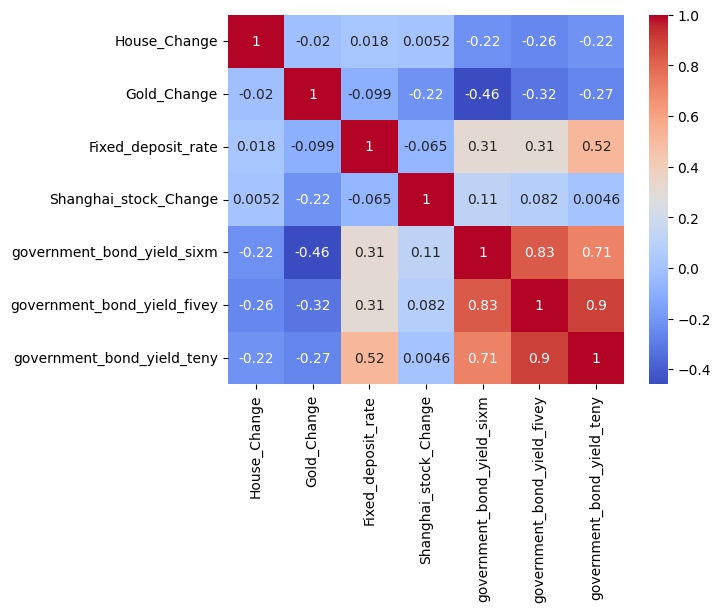

In [8]:
# In heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

## **New Regression Formular Without Assets with Weak Correlation**

according correlation and p valuse adjust the model if 0.00 to 0.19: Very weak correlation

In [9]:
import statsmodels.api as sm

# Model for House_Change
lm_house_on_others_new = sm.OLS(data['House_Change'], sm.add_constant(data[['log_core_inflation', 'government_bond_yield_sixm', 
                                                                             'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()

# Model for Gold_Change
lm_gold_on_others_new = sm.OLS(data['Gold_Change'], sm.add_constant(data[['log_core_inflation', 'Shanghai_stock_Change', 
                                                                           'government_bond_yield_sixm', 'government_bond_yield_fivey', 
                                                                           'government_bond_yield_teny']])).fit()

# Model for Fixed_deposit_rate
lm_fixed_on_others_new = sm.OLS(data['Fixed_deposit_rate'], sm.add_constant(data[['log_core_inflation', 'House_Change', 
                                                                                 'government_bond_yield_sixm', 'government_bond_yield_fivey', 
                                                                                 'government_bond_yield_teny']])).fit()

# Model for Shanghai_stock_Change
lm_stock_on_others_new = sm.OLS(data['Shanghai_stock_Change'], sm.add_constant(data[['log_core_inflation', 'Gold_Change']])).fit()

# Model for government_bond_yield_sixm
lm_sixm_on_others_new = sm.OLS(data['government_bond_yield_sixm'], sm.add_constant(data[['log_core_inflation', 'House_Change', 
                                                                                        'Gold_Change', 'Fixed_deposit_rate', 
                                                                                        'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()

# Model for government_bond_yield_fivey
lm_fivey_on_others_new = sm.OLS(data['government_bond_yield_fivey'], sm.add_constant(data[['log_core_inflation', 'House_Change', 
                                                                                          'Gold_Change', 'Fixed_deposit_rate', 
                                                                                          'government_bond_yield_sixm', 'government_bond_yield_teny']])).fit()

# Model for government_bond_yield_teny
lm_teny_on_others_new = sm.OLS(data['government_bond_yield_teny'], sm.add_constant(data[['log_core_inflation', 'House_Change', 
                                                                                        'Gold_Change', 'Fixed_deposit_rate', 
                                                                                        'government_bond_yield_sixm', 'government_bond_yield_fivey']])).fit()

# Store the models in lists
models_all = [lm_house_on_others_new, lm_gold_on_others_new, lm_fixed_on_others_new, lm_stock_on_others_new, lm_sixm_on_others_new, lm_fivey_on_others_new, lm_teny_on_others_new]
model_names_all = ["house", "gold", "fixed", "stock", "sixm", "fivey", "teny"]

### Displaying the summaries

In [10]:
summary = summary_col(models_all, stars=True, model_names=model_names_all)
with open ('../data/summary.pkl', 'wb') as file:
    pickle.dump(summary, file)

summary

<class 'statsmodels.iolib.summary2.Summary'>
"""

==================================================================================================
                             house      gold     fixed      stock      sixm     fivey       teny  
--------------------------------------------------------------------------------------------------
Fixed_deposit_rate                                                  0.1450    -0.1304*** 0.1784***
                                                                    (0.0921)  (0.0409)   (0.0381) 
Gold_Change                                               -0.3603   -0.0178** 0.0019     -0.0008  
                                                          (0.2533)  (0.0073)  (0.0038)   (0.0040) 
House_Change                                   0.0102               -0.0055   -0.0009    -0.0013  
                                               (0.0147)             (0.0087)  (0.0042)   (0.0044) 
R-squared                   0.1032   0.2514    0.4432     0.0485    0.7575    0.9093     0.8825   
R-squared Adj.              0.0113   0.1529    0.3699     0.0021    0.7182    0.8945     0.8635   
Shanghai_stock_Change                -0.1031                                                      
                                     (0.0863)                                                     
const                       10.4751  12.2054   0.6726     0.3191    -0.2136   0.0905     0.3616*  
                            (7.4499) (8.1628)  (0.7010)   (5.3414)  (0.4262)  (0.2068)   (0.2079) 
government_bond_yield_fivey -3.8398  3.5588    -1.6439***           1.2875***            0.8695***
                            (5.5431) (6.1055)  (0.5120)             (0.2648)             (0.0947) 
government_bond_yield_sixm  -0.5431  -7.1134** 0.3924                         0.3027***  -0.1307  
                            (2.7551) (3.0224)  (0.2531)                       (0.0623)   (0.0803) 
government_bond_yield_teny  0.9188   -0.8347   2.0842***            -0.5110   0.7995***           
                            (4.7937) (5.3106)  (0.4403)             (0.3141)  (0.0870)            
log_core_inflation          9.5557   0.5550    -0.2249    2.0280    0.3541    -0.0650    0.1037   
                            (7.8963) (8.6524)  (0.7384)   (15.2608) (0.4290)  (0.2097)   (0.2183) 
==================================================================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

# **Assumption Check**

In [11]:
def check_assumptions(model):
    # Check Linearity
    # Plotting the observed vs predicted values
    plt.scatter(model.fittedvalues, model.model.endog)
    plt.xlabel('Predicted values')
    plt.ylabel('Observed values')
    plt.title('Check for Linearity')
    plt.show()

    # Check Independence of Residuals
    # Plotting the residuals vs predicted values
    plt.scatter(model.fittedvalues, model.resid)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Check for Independence of Residuals')
    plt.show()

    # Check Homoscedasticity
    # Plotting the predicted values vs residuals
    plt.scatter(model.fittedvalues, np.sqrt(np.abs(model.resid)))
    plt.xlabel('Predicted values')
    plt.ylabel('Sqrt of the Absolute Residuals')
    plt.title('Check for Homoscedasticity')
    plt.show()

    # Check Normality of Residuals
    # Histogram of the residuals
    plt.hist(model.resid, bins=30)
    plt.title('Histogram of Residuals')
    plt.show()
    
    # QQ plot
    sm.qqplot(model.resid, line='s')
    plt.title('QQ Plot')
    plt.show()

    # Check Multicollinearity
    # Calculating VIF for each variable
    X = model.model.exog
    vif_data = pd.DataFrame()
    vif_data["feature"] = model.model.exog_names
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    print(vif_data)

Assumption checks for house model


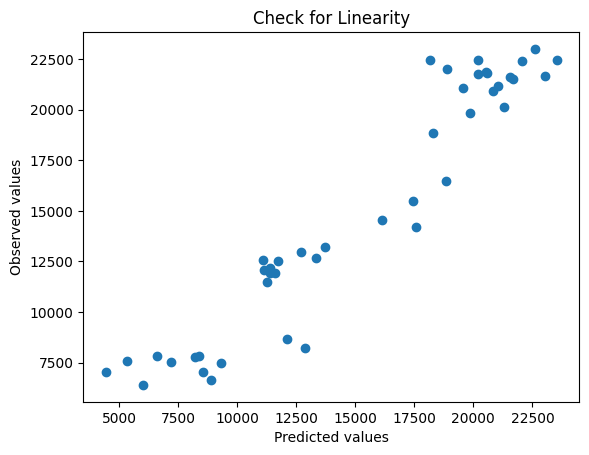

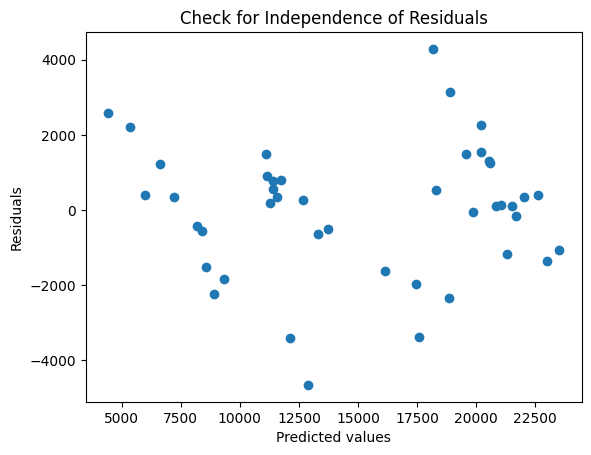

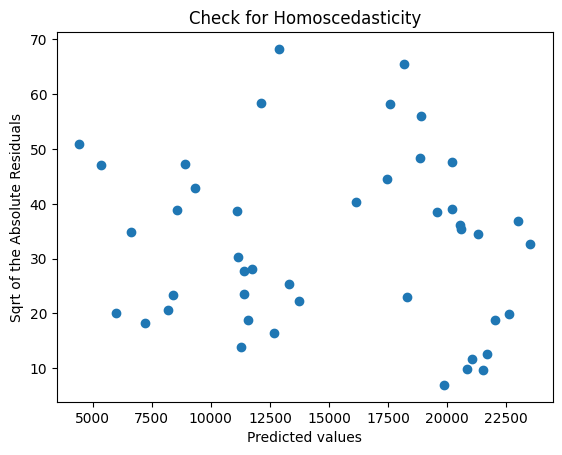

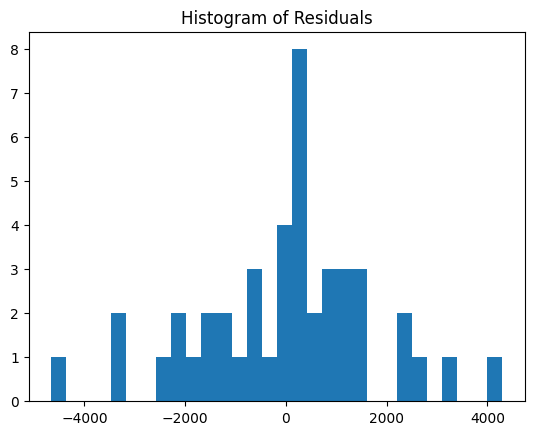

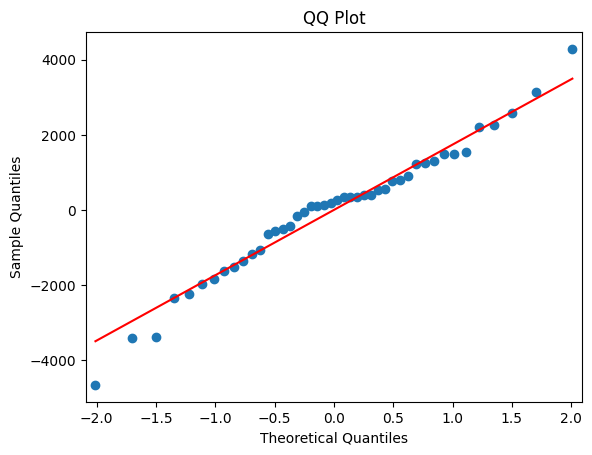

                      feature         VIF
0                   Intercept  370.694384
1    np.log1p(core_inflation)    1.257879
2                  Gold_price    1.460111
3          Fixed_deposit_rate    2.164727
4        Shanghai_stock_index    1.877528
5  government_bond_yield_sixm    2.132539
6  government_bond_yield_teny    2.792623

--------------------------------------------------

Assumption checks for gold model


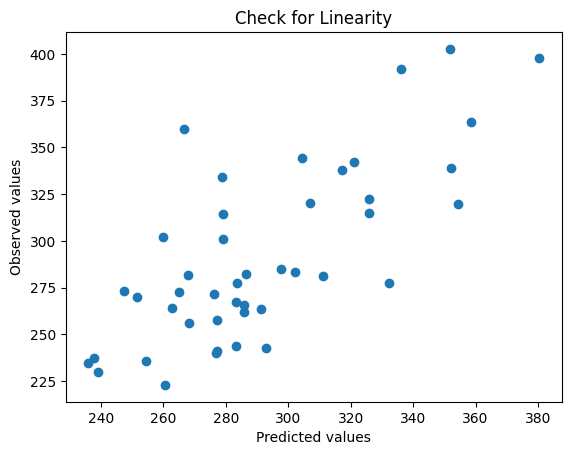

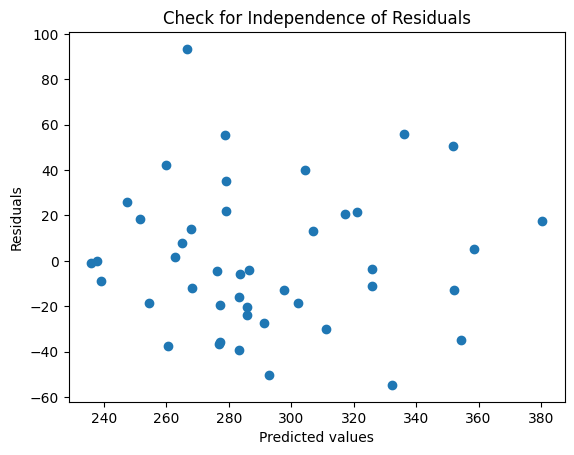

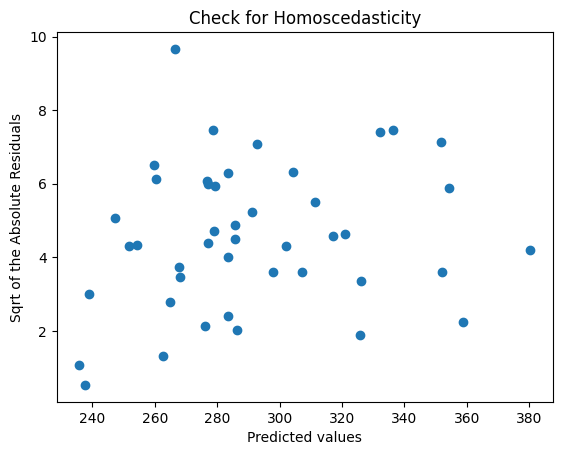

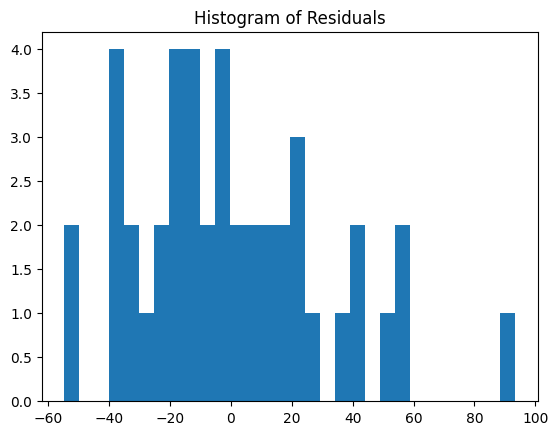

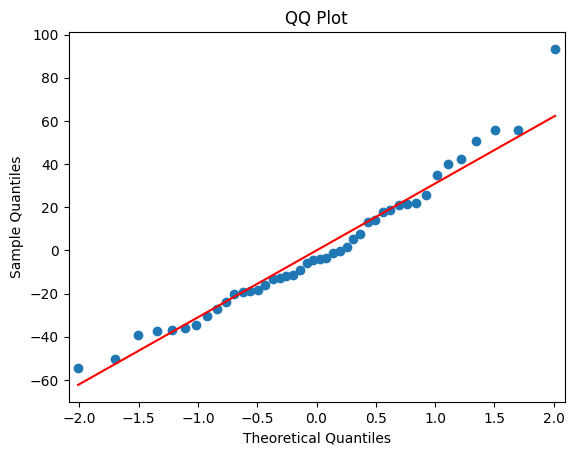

                       feature         VIF
0                    Intercept  393.793319
1     np.log1p(core_inflation)    1.117094
2                  House_price    7.294132
3           Fixed_deposit_rate    7.710695
4   government_bond_yield_sixm    3.722707
5  government_bond_yield_fivey   11.504337
6   government_bond_yield_teny    8.866874

--------------------------------------------------

Assumption checks for fixed model


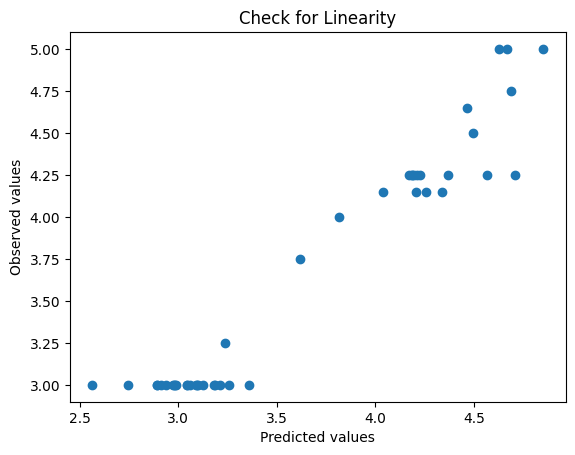

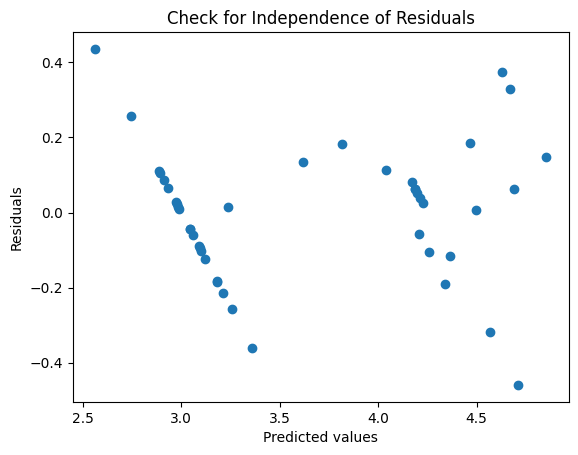

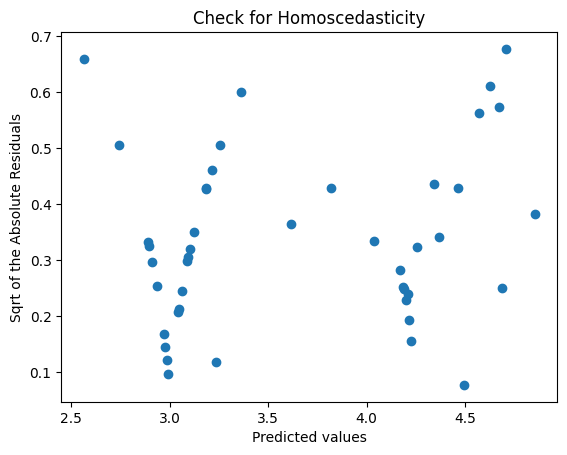

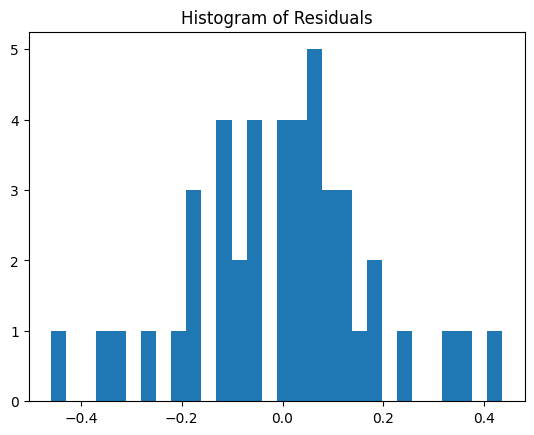

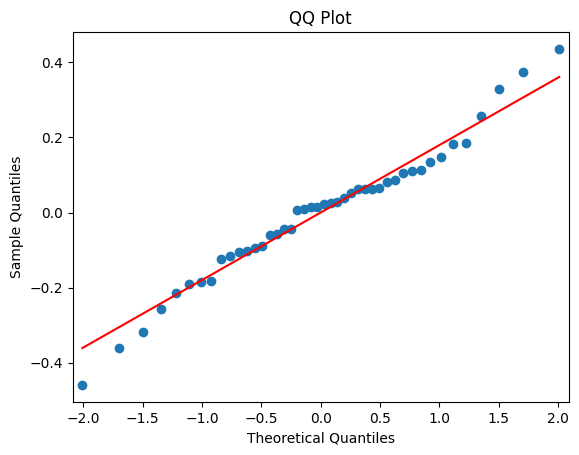

                       feature         VIF
0                    Intercept  340.517638
1     np.log1p(core_inflation)    1.253974
2                  House_price    2.031862
3                   Gold_price    1.480439
4         Shanghai_stock_index    1.642569
5   government_bond_yield_sixm    3.503838
6  government_bond_yield_fivey   11.502628
7   government_bond_yield_teny    8.859687

--------------------------------------------------

Assumption checks for stock model


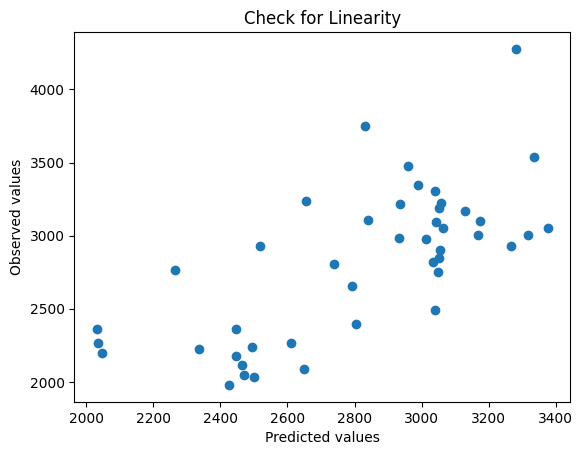

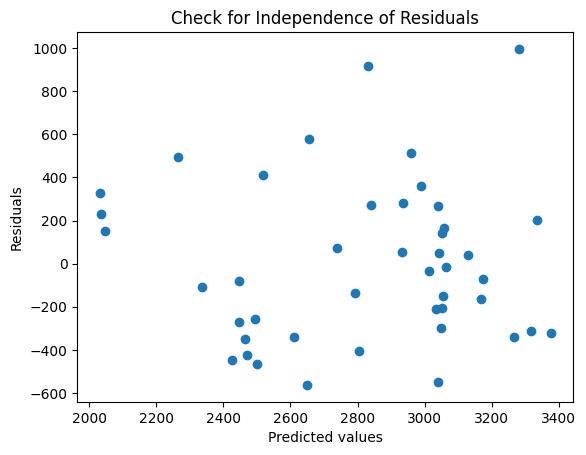

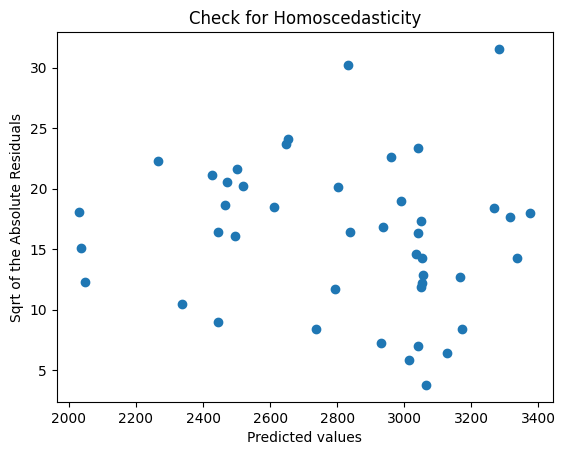

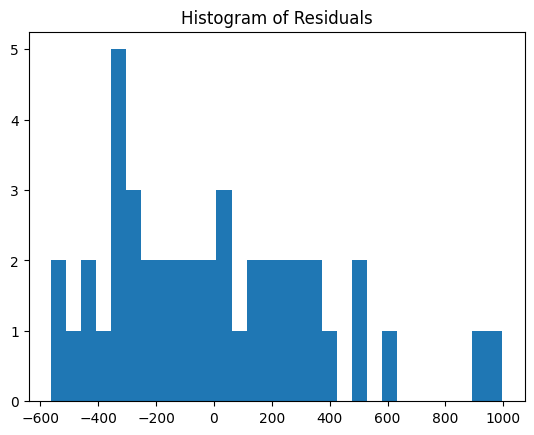

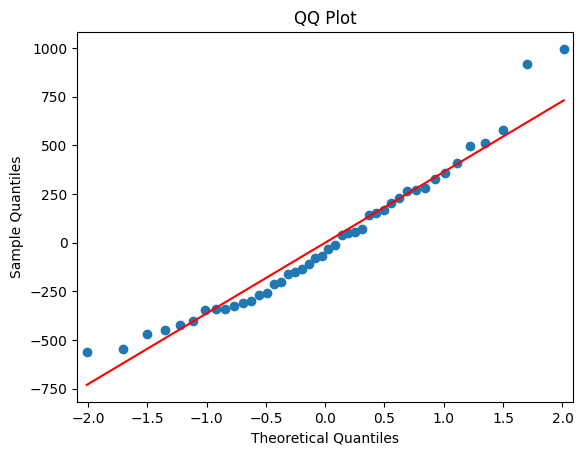

                       feature         VIF
0                    Intercept  393.793319
1     np.log1p(core_inflation)    1.117094
2                  House_price    7.294132
3           Fixed_deposit_rate    7.710695
4   government_bond_yield_sixm    3.722707
5  government_bond_yield_fivey   11.504337
6   government_bond_yield_teny    8.866874

--------------------------------------------------

Assumption checks for sixm model


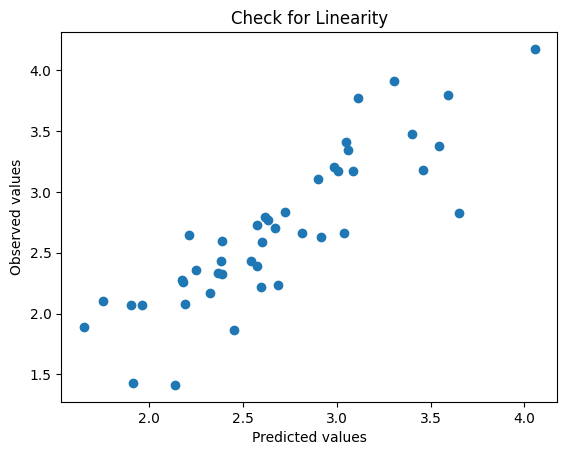

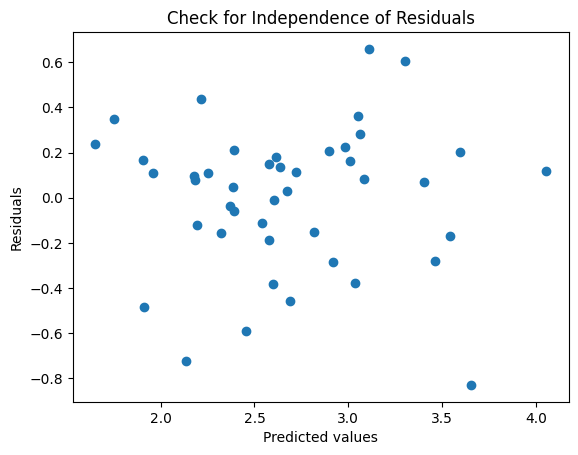

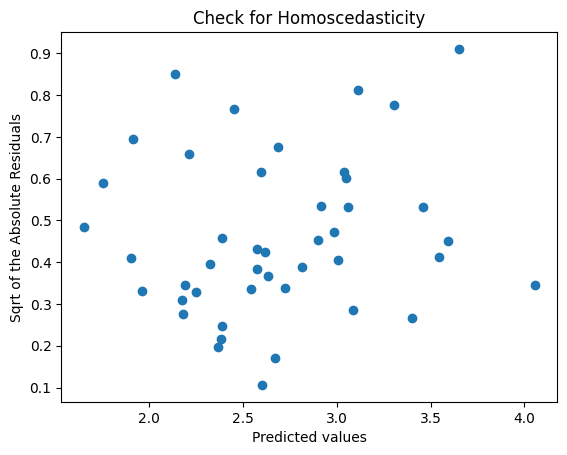

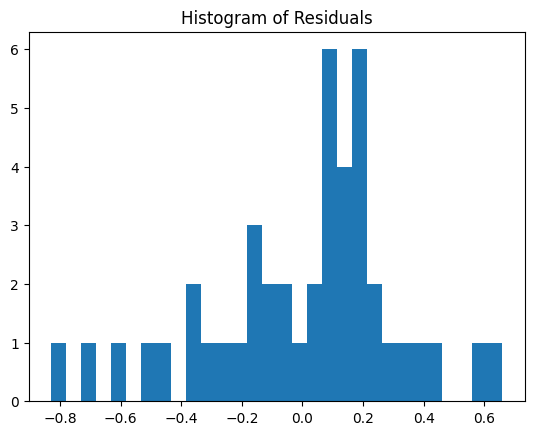

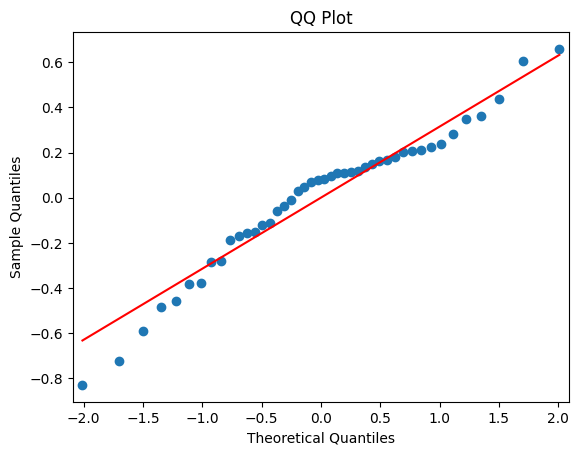

                       feature         VIF
0                    Intercept  671.123217
1     np.log1p(core_inflation)    1.248876
2                  House_price   10.908304
3                   Gold_price    2.140821
4           Fixed_deposit_rate   14.043746
5         Shanghai_stock_index    1.973311
6  government_bond_yield_fivey    8.022270
7   government_bond_yield_teny    8.710745

--------------------------------------------------

Assumption checks for fivey model


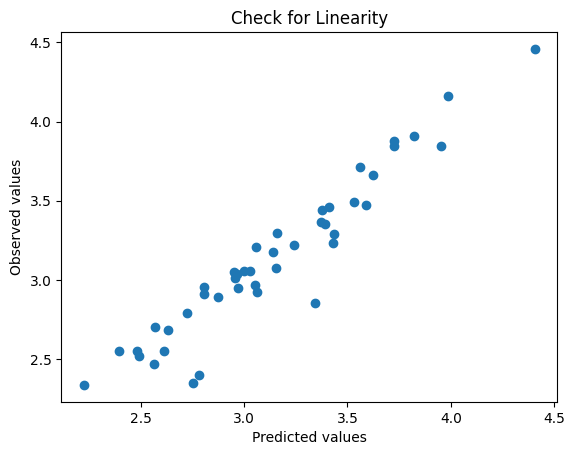

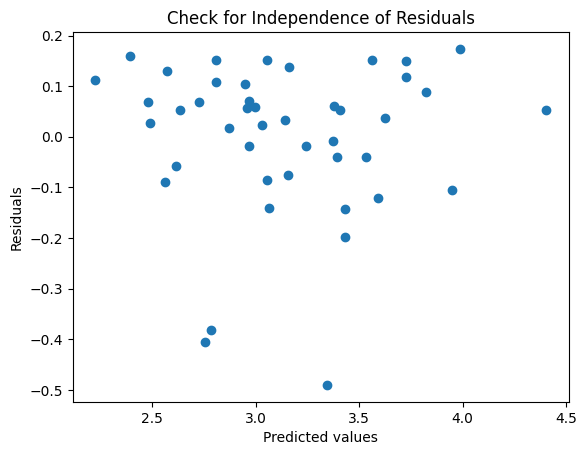

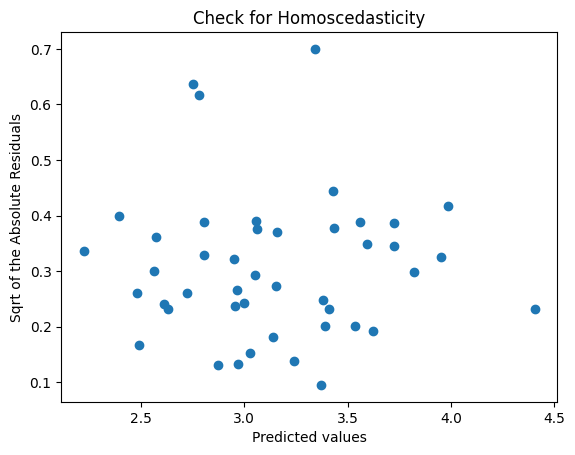

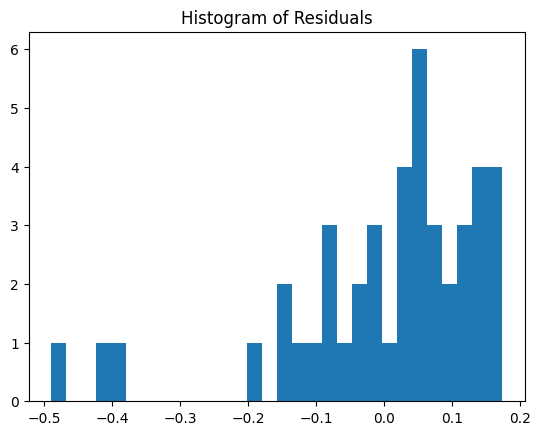

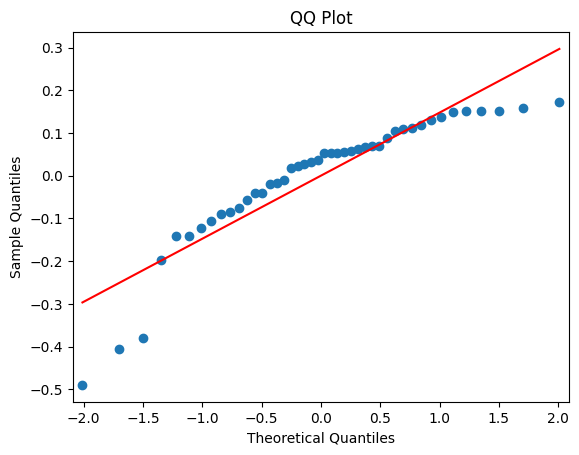

                      feature         VIF
0                   Intercept  370.694384
1    np.log1p(core_inflation)    1.257879
2                  Gold_price    1.460111
3          Fixed_deposit_rate    2.164727
4        Shanghai_stock_index    1.877528
5  government_bond_yield_sixm    2.132539
6  government_bond_yield_teny    2.792623

--------------------------------------------------

Assumption checks for teny model


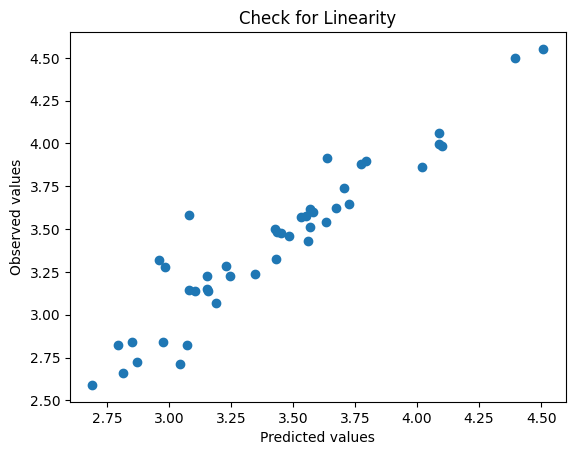

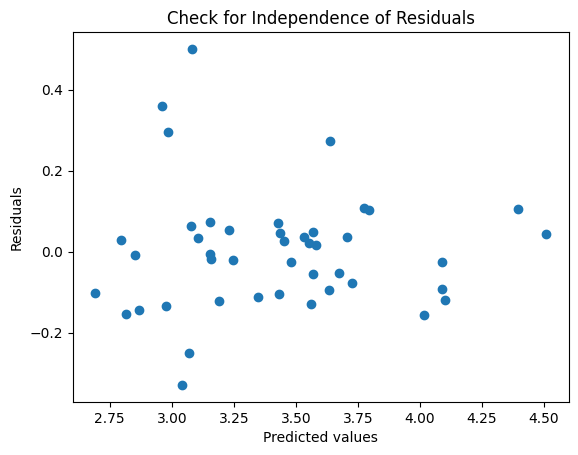

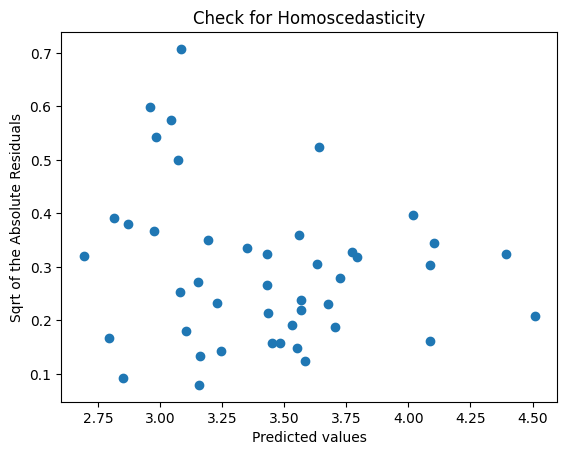

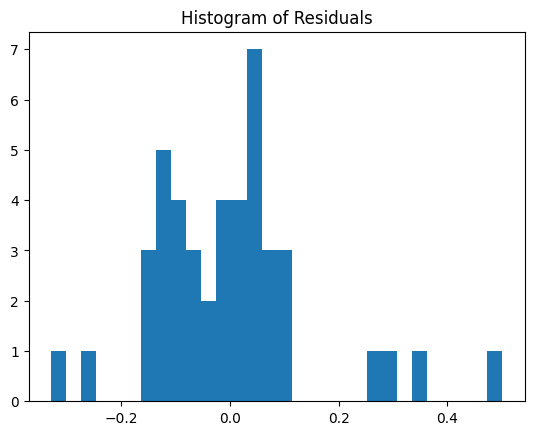

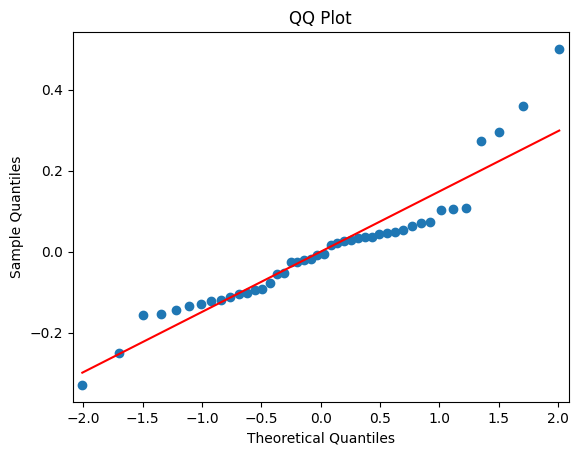

                       feature         VIF
0                    Intercept  669.980313
1     np.log1p(core_inflation)    1.254663
2                  House_price   11.863571
3                   Gold_price    2.159729
4           Fixed_deposit_rate   15.029335
5         Shanghai_stock_index    1.971737
6   government_bond_yield_sixm    3.686699
7  government_bond_yield_fivey    3.622268

--------------------------------------------------



In [12]:
# Defining the models
model_formulas = {
    "house": "House_price ~ np.log1p(core_inflation) + Gold_price + Fixed_deposit_rate + Shanghai_stock_index + government_bond_yield_sixm + government_bond_yield_teny",
    "gold": "Gold_price ~ np.log1p(core_inflation) + House_price + Fixed_deposit_rate + government_bond_yield_sixm + government_bond_yield_fivey + government_bond_yield_teny",
    "fixed": "Fixed_deposit_rate ~ np.log1p(core_inflation) + House_price + Gold_price + Shanghai_stock_index + government_bond_yield_sixm + government_bond_yield_fivey + government_bond_yield_teny",
    "stock": "Shanghai_stock_index ~ np.log1p(core_inflation) + House_price + Fixed_deposit_rate + government_bond_yield_sixm + government_bond_yield_fivey + government_bond_yield_teny",
    "sixm": "government_bond_yield_sixm ~ np.log1p(core_inflation) + House_price + Gold_price + Fixed_deposit_rate + Shanghai_stock_index + government_bond_yield_fivey + government_bond_yield_teny",
    "fivey": "government_bond_yield_fivey ~ np.log1p(core_inflation) + Gold_price + Fixed_deposit_rate + Shanghai_stock_index + government_bond_yield_sixm + government_bond_yield_teny",
    "teny": "government_bond_yield_teny ~ np.log1p(core_inflation) + House_price + Gold_price + Fixed_deposit_rate + Shanghai_stock_index + government_bond_yield_sixm + government_bond_yield_fivey"
}

# Creating and fitting the models
models = {name: sm.OLS.from_formula(formula, data).fit() for name, formula in model_formulas.items()}
with open('../data/model.pkl', 'wb') as file:
    # Use pickle.dump() to write the data object to the file
    pickle.dump(models, file)
# Looping through each model in 'models_all_new' and 'models_2_new'
for model_name, model in models.items():
    print(f"Assumption checks for {model_name} model")
    check_assumptions(model)
    print("\n" + "-"*50 + "\n")

In [13]:
models

{'house': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1f3bb6db6d0>,
 'gold': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1f3e0fd7820>,
 'fixed': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1f3e0fd58a0>,
 'stock': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1f3e0fd4490>,
 'sixm': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1f3e0fd4af0>,
 'fivey': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1f3e0fccbb0>,
 'teny': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1f3e0fcc280>}

In [14]:
# Plot change percentage using plotly express
fig = px.line(data, x='Time', y=['House_proportion', 'Gold_proportion', 'Fixed_deposit_proportion',
                                  'Shanghai_stock_proportion', 'Gover_sixm_proportion', 'Gover_fivey_proportion',
                                  'Gover_teny_proportion'],
              line_shape='linear', labels={'value': 'Return Rate'}, title='Multiple Lines for Each Asset vs. Inflation Over Time')

#   Show the plot
fig.show()